In [3]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import arviz as az
import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model import BaseModel
from hbmep.model import functional as F
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(
    format=FORMAT,
    level=logging.INFO,
    force=True
)


In [4]:
class MixtureModel(BaseModel):
    NAME = "mixture_model"

    def __init__(self, config: Config):
        super(MixtureModel, self).__init__(config=config)

    def _model(self, features, intensity, response_obs=None):
        features, n_features = features
        intensity, n_data = intensity
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        feature1 = features[1].reshape(-1,)

        with numpyro.plate(site.n_response, self.n_response):
            """ Global Priors """
            b_scale_global_scale = numpyro.sample("b_scale_global_scale", dist.HalfNormal(5))
            v_scale_global_scale = numpyro.sample("v_scale_global_scale", dist.HalfNormal(5))

            L_scale_global_scale = numpyro.sample("L_scale_global_scale", dist.HalfNormal(.5))
            ell_scale_global_scale = numpyro.sample("ell_scale_global_scale", dist.HalfNormal(5))
            H_scale_global_scale = numpyro.sample("H_scale_global_scale", dist.HalfNormal(5))

            g_1_scale_global_scale = numpyro.sample("g_1_scale_global_scale", dist.HalfNormal(5))
            g_2_scale_global_scale = numpyro.sample("g_2_scale_global_scale", dist.HalfNormal(5))

            with numpyro.plate(site.n_features[1], n_features[1]):
                """ Hyper-priors """
                a_mean = numpyro.sample("a_mean", dist.TruncatedNormal(50., 20., low=0))
                a_scale = numpyro.sample("a_scale", dist.HalfNormal(30.))

                b_scale_raw = numpyro.sample("b_scale_raw", dist.HalfNormal(scale=1))
                b_scale = numpyro.deterministic("b_scale", jnp.multiply(b_scale_global_scale, b_scale_raw))

                v_scale_raw = numpyro.sample("v_scale_raw", dist.HalfNormal(scale=1))
                v_scale = numpyro.deterministic("v_scale", jnp.multiply(v_scale_global_scale, v_scale_raw))

                L_scale_raw = numpyro.sample("L_scale_raw", dist.HalfNormal(scale=1))
                L_scale = numpyro.deterministic("L_scale", jnp.multiply(L_scale_global_scale, L_scale_raw))

                ell_scale_raw = numpyro.sample("ell_scale_raw", dist.HalfNormal(scale=1))
                ell_scale = numpyro.deterministic("ell_scale", jnp.multiply(ell_scale_global_scale, ell_scale_raw))

                H_scale_raw = numpyro.sample("H_scale_raw", dist.HalfNormal(scale=1))
                H_scale = numpyro.deterministic("H_scale", jnp.multiply(H_scale_global_scale, H_scale_raw))

                g_1_scale_raw = numpyro.sample("g_1_scale_raw", dist.HalfNormal(scale=1))
                g_1_scale = numpyro.deterministic("g_1_scale", jnp.multiply(g_1_scale_global_scale, g_1_scale_raw))

                g_2_scale_raw = numpyro.sample("g_2_scale_raw", dist.HalfNormal(scale=1))
                g_2_scale = numpyro.deterministic("g_2_scale", jnp.multiply(g_2_scale_global_scale, g_2_scale_raw))

                with numpyro.plate(site.n_features[0], n_features[0]):
                    """ Priors """
                    a = numpyro.sample(
                        site.a, dist.TruncatedNormal(a_mean, a_scale, low=0)
                    )

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, jnp.multiply(b_scale, b_raw))

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, jnp.multiply(v_scale, v_raw))

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, jnp.multiply(L_scale, L_raw))

                    ell_raw = numpyro.sample("ell_raw", dist.HalfNormal(scale=1))
                    ell = numpyro.deterministic(site.ell, jnp.multiply(ell_scale, ell_raw))

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, jnp.multiply(H_scale, H_raw))

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, jnp.multiply(g_1_scale, g_1_raw))

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, jnp.multiply(g_2_scale, g_2_raw))

        """ Outlier Distribution """
        outlier_prob = numpyro.sample("outlier_prob", dist.Uniform(0., .01))
        outlier_scale = numpyro.sample("outlier_scale", dist.HalfNormal(10))

        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate(site.n_data, n_data):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    F.rectified_logistic(
                        x=intensity,
                        a=a[feature0, feature1],
                        b=b[feature0, feature1],
                        v=v[feature0, feature1],
                        L=L[feature0, feature1],
                        ell=ell[feature0, feature1],
                        H=H[feature0, feature1]
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[feature0, feature1] + jnp.true_divide(g_2[feature0, feature1], mu)
                )

                q = numpyro.deterministic("q", outlier_prob * jnp.ones((n_data, self.n_response)))
                bg_scale = numpyro.deterministic("bg_scale", outlier_scale * jnp.ones((n_data, self.n_response)))

                mixing_distribution = dist.Categorical(
                    probs=jnp.stack([1 - q, q], axis=-1)
                )
                component_distributions=[
                    dist.Gamma(concentration=jnp.multiply(mu, beta), rate=beta),
                    dist.HalfNormal(scale=bg_scale)
                ]

                """ Mixture """
                Mixture = dist.MixtureGeneral(
                    mixing_distribution=mixing_distribution,
                    component_distributions=component_distributions
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    Mixture,
                    obs=response_obs
                )



In [5]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/tms/config.toml"
config = Config(toml_path=toml_path)
config.BUILD_DIR = os.path.join(config.BUILD_DIR, "render-model")
config.FEATURES = ["participant", "participant_condition"]
config.RESPONSE = ['PKPK_APB', 'PKPK_ECR', 'PKPK_FCR']
config.MCMC_PARAMS["num_warmup"] = 5000
config.MCMC_PARAMS["num_samples"] = 1000
model = MixtureModel(config=config)

src = "/home/vishu/data/hbmep-processed/human/tms/proc_2023-12-20.csv"
df = pd.read_csv(src)
df, encoder_dict = model.load(df=df)
# mcmc, posterior_samples = model.run_inference(df=df)


2023-12-21 10:58:15,490 - hbmep.model.baseline - INFO - Initialized mixture_model
2023-12-21 10:58:15,504 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/paper/tms/render-model
2023-12-21 10:58:15,505 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/paper/tms/render-model
2023-12-21 10:58:15,506 - hbmep.dataset.core - WARNING - Total non-positive observations: 0
2023-12-21 10:58:15,507 - hbmep.dataset.core - WARNING - Total missing observations: 0
2023-12-21 10:58:15,507 - hbmep.dataset.core - INFO - Processing data ...
2023-12-21 10:58:15,509 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


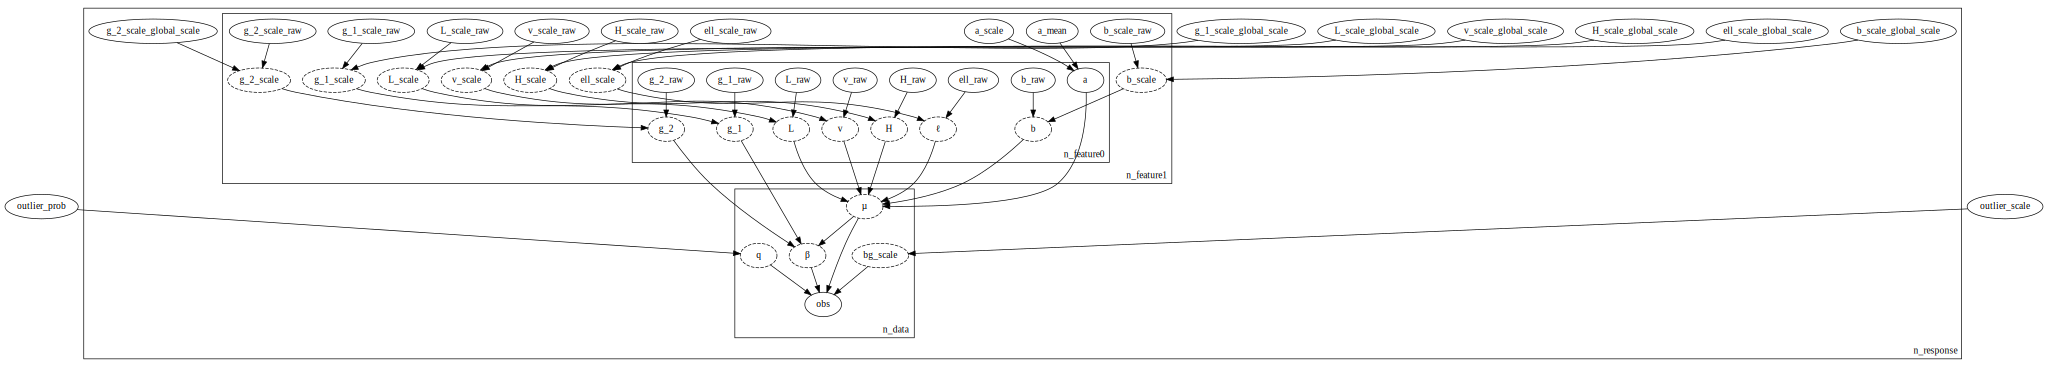

In [11]:
numpyro.render_model(model._model, model_args=(*model._collect_regressor(df=df),))

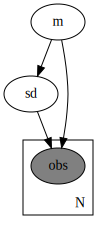

In [3]:
data = jnp.ones(10)
numpyro.render_model(model, model_args=(data,))


In [2]:
class RectifiedLogistic(BaseModel):
    LINK = "rectified_logistic"

    def __init__(self, config: Config):
        super(RectifiedLogistic, self).__init__(config=config)

    def _model(self, features, intensity, response_obs=None):
        features, n_features = features
        intensity, n_data = intensity
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        feature1 = features[1].reshape(-1,)

        with numpyro.plate(site.n_response, self.n_response):
            """ Global Priors """
            b_scale_global_scale = numpyro.sample("b_scale_global_scale", dist.HalfNormal(100))
            v_scale_global_scale = numpyro.sample("v_scale_global_scale", dist.HalfNormal(100))

            L_scale_global_scale = numpyro.sample("L_scale_global_scale", dist.HalfNormal(.05))
            ell_scale_global_scale = numpyro.sample("ell_scale_global_scale", dist.HalfNormal(100))
            H_scale_global_scale = numpyro.sample("H_scale_global_scale", dist.HalfNormal(1))

            g_1_scale_global_scale = numpyro.sample("g_1_scale_global_scale", dist.HalfNormal(100))
            g_2_scale_global_scale = numpyro.sample("g_2_scale_global_scale", dist.HalfNormal(100))

            with numpyro.plate(site.n_features[1], n_features[1]):
                """ Hyper-priors """
                a_mean = numpyro.sample("a_mean", dist.TruncatedNormal(150, 100, low=0))
                a_scale = numpyro.sample("a_scale", dist.HalfNormal(100.0))

                b_scale_raw = numpyro.sample("b_scale_raw", dist.HalfNormal(scale=1))
                b_scale = numpyro.deterministic("b_scale", jnp.multiply(b_scale_global_scale, b_scale_raw))

                v_scale_raw = numpyro.sample("v_scale_raw", dist.HalfNormal(scale=1))
                v_scale = numpyro.deterministic("v_scale", jnp.multiply(v_scale_global_scale, v_scale_raw))

                L_scale_raw = numpyro.sample("L_scale_raw", dist.HalfNormal(scale=1))
                L_scale = numpyro.deterministic("L_scale", jnp.multiply(L_scale_global_scale, L_scale_raw))

                ell_scale_raw = numpyro.sample("ell_scale_raw", dist.HalfNormal(scale=1))
                ell_scale = numpyro.deterministic("sigma_ell", jnp.multiply(ell_scale_global_scale, ell_scale_raw))

                H_scale_raw = numpyro.sample("H_scale_raw", dist.HalfNormal(scale=1))
                H_scale = numpyro.deterministic("H_scale", jnp.multiply(H_scale_global_scale, H_scale_raw))

                g_1_scale_raw = numpyro.sample("g_1_scale_raw", dist.HalfNormal(scale=1))
                g_1_scale = numpyro.deterministic("g_1_scale", jnp.multiply(g_1_scale_global_scale, g_1_scale_raw))

                g_2_scale_raw = numpyro.sample("g_2_scale_raw", dist.HalfNormal(scale=1))
                g_2_scale = numpyro.deterministic("g_2_scale", jnp.multiply(g_2_scale_global_scale, g_2_scale_raw))

                with numpyro.plate(site.n_features[0], n_features[0]):
                    """ Priors """
                    a = numpyro.sample(site.a, dist.TruncatedNormal(a_mean, a_scale, low=0))

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, jnp.multiply(b_scale, b_raw))

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, jnp.multiply(v_scale, v_raw))

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, jnp.multiply(L_scale, L_raw))

                    ell_raw = numpyro.sample("ell_raw", dist.HalfNormal(scale=1))
                    ell = numpyro.deterministic(site.ell, jnp.multiply(ell_scale, ell_raw))

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, jnp.multiply(H_scale, H_raw))

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, jnp.multiply(g_1_scale, g_1_raw))

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, jnp.multiply(g_2_scale, g_2_raw))

        # """ Outlier Distribution """
        # outlier_prob = numpyro.sample("outlier_prob", dist.Uniform(0., .05))
        # outlier_scale = numpyro.sample("outlier_scale", dist.HalfNormal(10))

        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate(site.n_data, n_data):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    F.rectified_logistic(
                        x=intensity,
                        a=a[feature0, feature1],
                        b=b[feature0, feature1],
                        v=v[feature0, feature1],
                        L=L[feature0, feature1],
                        ell=ell[feature0, feature1],
                        H=H[feature0, feature1]
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[feature0, feature1] + jnp.true_divide(g_2[feature0, feature1], mu)
                )

                # q = numpyro.deterministic("q", outlier_prob * jnp.ones((n_data, self.n_response)))
                # bg_scale = numpyro.deterministic("bg_scale", outlier_scale * jnp.ones((n_data, self.n_response)))

                # mixing_distribution = dist.Categorical(
                #     probs=jnp.stack([1 - q, q], axis=-1)
                # )
                # component_distributions=[
                #     dist.Gamma(concentration=jnp.multiply(mu, beta), rate=beta),
                #     dist.HalfNormal(scale=bg_scale)
                # ]

                # """ Mixture """
                # Mixture = dist.MixtureGeneral(
                #     mixing_distribution=mixing_distribution,
                #     component_distributions=component_distributions
                # )

                # """ Observation """
                # numpyro.sample(
                #     site.obs,
                #     Mixture,
                #     obs=response_obs
                # )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    dist.Gamma(concentration=jnp.multiply(mu, beta), rate=beta),
                    obs=response_obs
                )



In [3]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/rats/J_RCML_000/config.toml"
CONFIG = Config(toml_path=toml_path)
CONFIG.BUILD_DIR = "/home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/new"
CONFIG.FEATURES = ["participant", "compound_position"]
CONFIG.RESPONSE = ["Biceps", "ECR"]
CONFIG.MCMC_PARAMS["num_warmup"] = 6000
CONFIG.MCMC_PARAMS["num_samples"] = 4000
CONFIG.MEP_MATRIX_PATH = "/home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/mat.npy"
CONFIG.MEP_RESPONSE = ["Biceps", "ECR"]

In [4]:
BASELINE = BaseModel(config=CONFIG)
BASELINE._make_dir(BASELINE.build_dir)

src = "/home/vishu/data/hbmep-processed/J_RCML_000/data.csv"
DF = pd.read_csv(src)

src = "/home/vishu/data/hbmep-processed/J_RCML_000/mat.npy"
MAT = np.load(src)
mep_response = ['LADM', 'LBiceps', 'LBicepsFemoris', 'LDeltoid', 'LECR', 'LFCR', 'LTriceps', 'RBiceps']

DF = DF.sort_values(by=[BASELINE.intensity]).copy()
MAT = MAT[DF.index.values]
DF = DF.reset_index(drop=True).copy()


In [5]:
c, muscle, const = ("amap08", "-C5M"), "LADM", 2.2
ind = DF[BASELINE.features].apply(tuple, axis=1).isin([c])
temp_DF = DF[ind].reset_index(drop=True).copy()
df = pd.DataFrame(
    temp_DF[BASELINE.intensity],
    columns=[BASELINE.intensity]
)
df[BASELINE.response[0]] = temp_DF[muscle] / const

mep_response_ind = [i for i, _response in enumerate(mep_response) if _response == muscle][0]
mat = MAT[ind, :, mep_response_ind][..., None]

c, muscle, const =("amap08", "C6M-C7L"), "LECR", 1
ind = DF[BASELINE.features].apply(tuple, axis=1).isin([c])
temp_DF = DF[ind].reset_index(drop=True).copy()
df[BASELINE.response[1]] = temp_DF[muscle] / const

mep_response_ind = [i for i, _response in enumerate(mep_response) if _response == muscle][0]
mat = np.concatenate([
    mat,
    MAT[ind, :, mep_response_ind][..., None]
], axis=-1)

df[BASELINE.features[0]] = 0
df[BASELINE.features[1]] = 0

dest = os.path.join(BASELINE.build_dir, "mat.npy")
np.save(dest, mat)


In [6]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/rats/J_RCML_000/config.toml"
config = Config(toml_path=toml_path)
config.BUILD_DIR = "/home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/new/fit"
config.FEATURES = ["participant", "compound_position"]
config.RESPONSE = ["Biceps", "ECR"]
config.MCMC_PARAMS["num_warmup"] = 6000
config.MCMC_PARAMS["num_samples"] = 4000
config.MEP_MATRIX_PATH = "/home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/mat.npy"
config.MEP_RESPONSE = ["Biceps", "ECR"]
model = RectifiedLogistic(config=config)

df, encoder_dict = model.load(df=df)
model.plot(df=df, encoder_dict=encoder_dict)

Total non-positive observations: 0
Total missing observations: 0


In [8]:
mcmc, posterior_samples = model.run_inference(df=df)


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [11]:
_posterior_samples = posterior_samples.copy()
# _posterior_samples["outlier_prob"] = _posterior_samples["outlier_prob"] * 0
prediction_df = model.make_prediction_dataset(df=df, num=1000)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=_posterior_samples)
model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=_posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)
model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-12-19 13:15:18,973 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-12-19 13:15:30,992 - hbmep.utils.utils - INFO - func:predict took: 12.02 sec
2023-12-19 13:15:30,994 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-12-19 13:15:31,713 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/new/fit/recruitment_curves.pdf
2023-12-19 13:15:31,714 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.72 sec
2023-12-19 13:15:31,714 - hbmep.model.baseline - INFO - Rendering posterior predictive checks ...
2023-12-19 13:15:37,005 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/new/fit/posterior_predictive_check.pdf
2023-12-19 13:15:37,006 - hbmep.utils.utils - INFO - func:predictive_checks_renderer took: 5.29 sec
2023-12-19 13:15:37,006 - hbmep.utils.utils - INFO - func:render_predictive_check took: 5.29 sec


In [12]:
time_const = 1000
obs = np.array(posterior_predictive[site.obs]) * time_const
obs_map = obs.mean(axis=0)
obs_hpdi = hpdi(obs, prob=.95)


In [32]:
a, b, v, L, ell, H = \
    posterior_samples[site.a], \
    posterior_samples[site.b], \
    posterior_samples[site.v], \
    posterior_samples[site.L], \
    posterior_samples[site.ell], \
    posterior_samples[site.H]

features, intensity,= model._collect_regressor(df=prediction_df)
features, n_features = features
intensity, n_data = intensity
intensity = intensity.reshape(-1, 1)
intensity = np.tile(intensity, (1, model.n_response))

feature0 = features[0].reshape(-1,)
feature1 = features[1].reshape(-1,)

params = [a, b, v, L, ell, H]
params = [u[:, feature0, feature1] for u in params]

fn_out = F.rectified_logistic(intensity, *tuple(params))
fn_out = np.array(fn_out)

fn_prime_out = F.prime(F.rectified_logistic, np.tile(intensity, (params[0].shape[0], 1, 1)), *tuple(params))
fn_prime_out = np.array(fn_prime_out) * time_const
fn_prime_out.shape


(16000, 1000, 2)

In [33]:
a_map = a.mean(axis=0)
obs_map = obs.mean(axis=0)

In [ ]:
dest

'/home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/mixture-model/a-meps.png'

In [36]:
import scipy.stats as stats

In [72]:
max_grad.max()

36.07370154529718

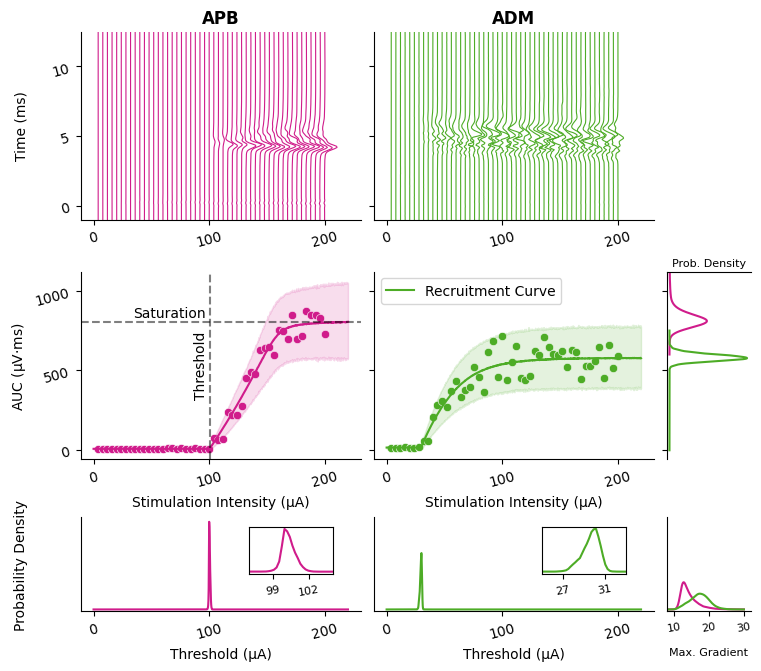

In [123]:
scatter_alpha = 1

a_, b_ = model.mep_window
time = np.linspace(a_, b_, mat.shape[1])
colors = [(0.6510, 0.3804, 0.1020), (0.2055, 0., 0.4000)]
colors = [(0.8157, 0.1098, 0.5451), (0.3020, 0.6745, 0.1490)]
const = [200, 100]

nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5 * ncols, 2.2 * nrows), squeeze=False, constrained_layout=True, height_ratios=[1, 1, .5], width_ratios=[1, 1, .3])

for muscle_ind in [0, 1]:
    ax = axes[0, muscle_ind]
    for k in range(mat.shape[0]):
        x = mat[k, :, muscle_ind] / const[muscle_ind]
        x += df[model.intensity].values[k]
        ax.plot(x, time * time_const, color=colors[muscle_ind], linewidth=.8, alpha=1)
    ax.set_yticks(np.array([0, 0.005, 0.01]) * time_const)
    ax.set_ylim(bottom=-0.001 * time_const, top=(model.mep_size_window[1] + (model.mep_size_window[0] - (-0.001))) * time_const)

    ax = axes[1, muscle_ind]
    sns.lineplot(x=prediction_df[model.intensity], y=obs.mean(axis=0)[..., muscle_ind], ax=ax, color=colors[muscle_ind], alpha=1, label="Recruitment Curve")
    sns.scatterplot(x=df[model.intensity], y=df[model.response[muscle_ind]] * time_const, color=colors[muscle_ind], alpha=1, ax=ax)
    ax.fill_between(
        prediction_df[model.intensity],
        obs_hpdi[0, ..., muscle_ind],
        obs_hpdi[1, ..., muscle_ind],
        color=colors[muscle_ind],
        alpha=.15
    )
    if ax == axes[1, 0]:
        ax.axvline(x=a_map[0, 0, muscle_ind], color="black", alpha=.5, linestyle="--")
        ax.text(a_map[0, 0, muscle_ind] - 1, obs_map.max(axis=0)[muscle_ind] - 60, "Threshold", rotation=90, va="top", ha="right")

    if ax == axes[1, 0]:
        ax.axhline(y=obs_map.max(axis=0)[muscle_ind], color="black", alpha=.5, linestyle="--")
        ax.text(a_map[0, 0, muscle_ind] - 35, obs_map.max(axis=0)[muscle_ind] + 10, "Saturation", va="bottom", ha="center")

    ax = axes[2, muscle_ind]
    samples = a[:, 0, 0, muscle_ind]
    kde = stats.gaussian_kde(samples)
    x_grid = prediction_df[model.intensity]
    # x_grid = np.linspace(samples.mean() - 20, samples.mean() + 20, 1000)
    density = kde(x_grid)
    # sns.kdeplot(a[:, 0, 0, muscle_ind], ax=ax, color=colors[muscle_ind])
    ax.plot(x_grid, density, color=colors[muscle_ind])
    ins = ax.inset_axes([0.6,0.4,0.3,0.5])
    ins.plot(x_grid, density, color=colors[muscle_ind])
    # sns.kdeplot(a[:, 0, 0, muscle_ind], ax=ins, color=colors[muscle_ind])
    ins.set_xlabel("")
    ins.set_ylabel("")
    if muscle_ind == 0:
        ins.set_xticks([99, 102])
        ins.set_xlim(left=97, right=104)
    if muscle_ind == 1:
        ins.set_xticks([27, 31])
        ins.set_xlim(left=25, right=33)
    ins.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        bottom=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True,
        labelleft=False,
        labelright=False,
        labelsize=8,
        labelrotation=10
    )

    ax = axes[1, 2]
    # ax.axhline(obs.mean(axis=0).max(axis=0)[muscle_ind], color="black", linestyle="--")
    if muscle_ind == 0:
        samples = (H[:, 0, 0, muscle_ind] * time_const) + 30
        x_grid = np.linspace(600, obs_hpdi.max() + 100, 5000)

    if muscle_ind == 1:
        samples = H[:, 0, 0, muscle_ind] * time_const + 20
        x_grid = np.linspace(0, 750, 5000)

    kde = stats.gaussian_kde(samples)
    # x_grid = np.linspace(0, obs_hpdi.max() + 30, 5000)
    density = kde(x_grid)
    ax.plot(density, x_grid, color=colors[muscle_ind])
    # sns.kdeplot(y=H[:, 0, 0, muscle_ind] * time_const + 30, ax=ax, color=colors[muscle_ind])

    ax = axes[2, 2]
    max_grad = fn_prime_out.max(axis=1)[..., muscle_ind]
    samples = max_grad
    kde = stats.gaussian_kde(samples)
    x_grid = np.linspace(8, 30, 1000)
    density = kde(x_grid)
    ax.plot(x_grid, density, color=colors[muscle_ind])

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.set_xlabel("")
        ax.set_ylabel("")

subset = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    sides = ['right', 'top']
    for side in sides:
        ax.spines[side].set_visible(False)
    if j == 0:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=True,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 1:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 2:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=10,
            labelsize=8
        )

subset = [(2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        labelleft=False,
    )


axes[0, 1].sharey(axes[0, 0])
axes[1, 1].sharey(axes[1, 0])

axes[0, 1].sharex(axes[0, 0])
axes[1, 0].sharex(axes[0, 0])
axes[1, 1].sharex(axes[0, 0])

axes[0, 0].set_xticks([0, 100, 200])
axes[0, 0].set_yticks([0, 5, 10])
axes[1, 0].set_yticks([0, 500, 1000])
# axes[1, 0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

axes[1, 1].legend(loc="upper left")
if axes[1, 0].get_legend():
    axes[1, 0].get_legend().set_visible(False)

axis_label_size = 10
axes[0, 0].set_ylabel("Time (ms)", size=axis_label_size)
axes[1, 0].set_ylabel("AUC (µV$\cdot$ms)", size=axis_label_size)

axes[1, 0].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)
axes[1, 1].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)

axes[2, 0].sharex(axes[0, 0])
axes[2, 1].sharex(axes[0, 0])
axes[2, 1].sharey(axes[2, 0])
axes[2, 0].set_ylim(bottom=-0.018)
axes[2, 0].set_ylabel("Probability Density")
# axes[2, 0].ticklabel_format(axis='y', style='sci', scilimits=(0, 2))

axes[2, 0].set_xlabel("Threshold (µA)", size=axis_label_size)
axes[2, 1].set_xlabel("Threshold (µA)", size=axis_label_size)

axes[2, 2].sharey(axes[2, 0])
axes[2, 2].set_xlim(left=8, right=32)
axes[2, 2].set_xticks([10, 20, 30])
axes[2, 2].set_xlabel("Max. Gradient", size=8)

ax = axes[0, 2]
sides = ['left', 'top', 'bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False
)

ax = axes[1, 2]
sides = ['bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False,
    labelrotation=10,
    labelsize=8
)
ax.set_xlabel("Prob. Density", size=8)
axes[1, 2].sharey(axes[1, 0])
# axes[1, 2].set_xlabel("Prob. Density", size=8)
axes[1, 2].xaxis.set_label_position('top')
# axes[1, 2].set_ylabel("Saturation (µV$\cdot$ms)", size=8)
axes[1, 2].set_xlim(left=-0.0006)
axes[1, 2].set_ylim(top=1000 + 120)

axes[1, 2].set_xticks([0, 0.015/2, 0.015])
# axes[1, 2].set_xticklabels([0.0, 0.1, 0.2])
# axes[1, 2].set_ylabel("Saturation (µA)", size=8)

axes[0, 0].set_title("APB", fontweight="bold")
axes[0, 1].set_title("ADM", fontweight="bold")

fig.align_xlabels()
fig.align_ylabels()

dest = os.path.join(model.build_dir, "a-meps-v2.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(model.build_dir, "a-meps-v2.png")
fig.savefig(dest, dpi=600)


In [35]:
dest

'/home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/new/fit/a-meps-v2.png'